In [1]:
import networkx as nx
import pandas as pd
import itertools
import json
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# Generate network

In [2]:
df = pd.read_csv('../data/orders_generated.csv')
df.columns = ['receipt', 'order']
df.head(2)

,receipt,order
0,0,1 pc chicken w/fries
1,0,1 pc. burger steak


In [3]:
orders = df.drop_duplicates().groupby('receipt')['order'].apply(list).values

In [4]:
G = nx.Graph()
for order in orders:
    for pair in itertools.combinations(order, 2):
        try:
            G[pair[0]][pair[1]]['weight'] += 1
        except:
            G.add_edge(pair[0], pair[1],weight=1)

In [5]:
G.edges(data=True)[:2]

[('1 pc chicken w/fries', '1 pc. burger steak', {'weight': 250}),
 ('1 pc chicken w/fries', 'coca-cola', {'weight': 250})]

/Users/jiah/anaconda/envs/pres/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/jiah/anaconda/envs/pres/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/jiah/anaconda/envs/pres/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/jiah/anaconda/envs/pres/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

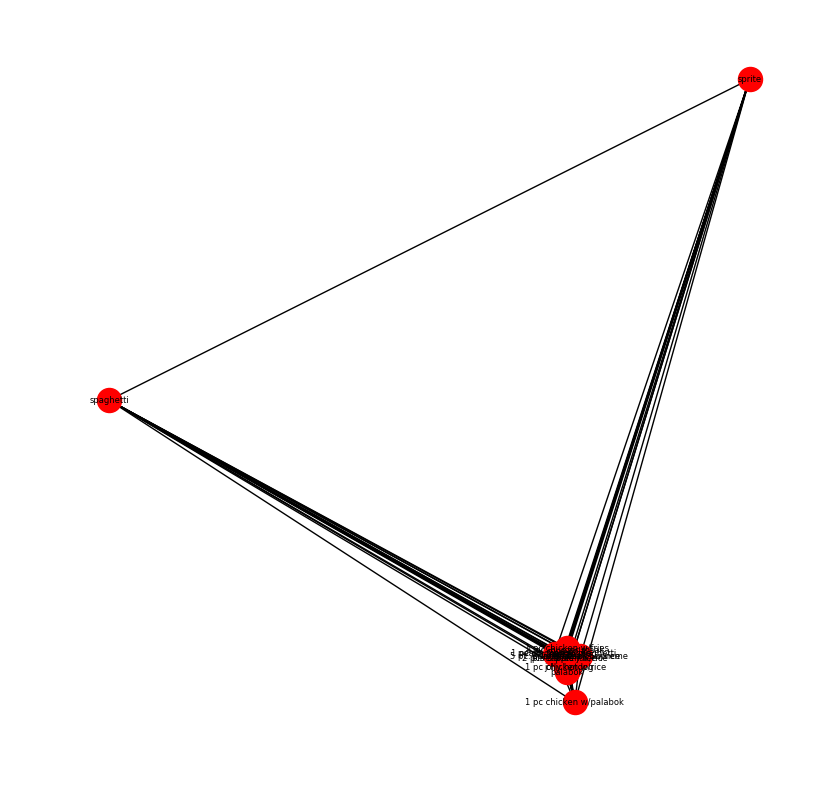

In [6]:
layout = nx.layout.spectral_layout(G)
labels=nx.draw_networkx_labels(G, pos=layout, font_size=6)
nx.draw(G, pos=layout) 
plt.gcf().set_size_inches(10,10)
plt.gcf().set_dpi(100)

In [7]:
nx.write_gml(G, '../data/orders.gml')

## Create csv and json

In [8]:
item = pd.DataFrame(index=df['order'].unique())
item['frequency'] = df.drop_duplicates()['order'].value_counts()
item['expectation'] = item['frequency']/len(df)
item

,frequency,expectation
1 pc chicken w/fries,250,0.037959
1 pc. burger steak,444,0.067416
coca-cola,489,0.074248
5 pc. shanghai rolls w/rice,305,0.046310
pineapple juice,275,0.041755
1 pc chicken w/spaghetti,589,0.089432
water,549,0.083359
jolly hotdog,171,0.025964
2 pcs chicken w/rice,309,0.046918
peach mango pie,258,0.039174


In [9]:
edges = pd.DataFrame(G.edges(data=True))
edges.columns = ['item1', 'item2', 'weight']
edges['weight'] = edges.weight.apply(lambda x: x['weight'])

In [10]:
pA_pB = (edges.item1.apply(lambda x: item.loc[x, 'expectation']) * 
         edges.item2.apply(lambda x: item.loc[x, 'expectation']))
edges['norm_weight'] = pA_pB/edges.weight
edges['norm_weight_item1'] = edges.weight / edges.item1.apply(lambda x: item.loc[x, 'frequency'])
edges['norm_weight_item2'] = edges.weight / edges.item2.apply(lambda x: item.loc[x, 'frequency'])

In [11]:
edges.to_csv('../data/jbee_small_network.csv', index=False)

In [12]:
edges.head(2).T.to_json()

'{"0":{"item1":"1 pc chicken w\\/fries","item2":"1 pc. burger steak","weight":250,"norm_weight":0.0000102362,"norm_weight_item1":1.0,"norm_weight_item2":0.5630630631},"1":{"item1":"1 pc chicken w\\/fries","item2":"coca-cola","weight":250,"norm_weight":0.0000112737,"norm_weight_item1":1.0,"norm_weight_item2":0.5112474438}}'

In [13]:
json.dumps([(row.to_json()) for ix, row in edges.head(2).iterrows()])

'["{\\"item1\\":\\"1 pc chicken w\\\\/fries\\",\\"item2\\":\\"1 pc. burger steak\\",\\"weight\\":250,\\"norm_weight\\":0.0000102362,\\"norm_weight_item1\\":1.0,\\"norm_weight_item2\\":0.5630630631}", "{\\"item1\\":\\"1 pc chicken w\\\\/fries\\",\\"item2\\":\\"coca-cola\\",\\"weight\\":250,\\"norm_weight\\":0.0000112737,\\"norm_weight_item1\\":1.0,\\"norm_weight_item2\\":0.5112474438}"]'

In [14]:
f = open('../data/jbee_small_network.json', 'w')
f.writelines(str([row.to_json() for ix, row in edges.iterrows()]))
f.close()

In [15]:
edges.head(2)

,item1,item2,weight,norm_weight,norm_weight_item1,norm_weight_item2
0,1 pc chicken w/fries,1 pc. burger steak,250,0.000010,1.0,0.563063
1,1 pc chicken w/fries,coca-cola,250,0.000011,1.0,0.511247


# Upsell

In [16]:
item0 = '2 pcs chicken w/rice'
def show_upsell(item0):
    p1 = edges[edges.item1==item0].loc[:,['item1', 'item2', 'weight', 'norm_weight_item1']]
    p2 = edges[edges.item2==item0].loc[:,['item2', 'item1', 'weight', 'norm_weight_item2']]
    p1.columns = ['item', 'pair', 'weight', 'upsell']
    p2.columns = ['item', 'pair', 'weight', 'upsell']
    p = pd.concat([p1,p2])
    display(p.sort_values('upsell', ascending=False))
show_upsell(item0)

,item,pair,weight,upsell
108,2 pcs chicken w/rice,peach mango pie,227,0.734628
64,2 pcs chicken w/rice,pineapple juice,204,0.660194
112,2 pcs chicken w/rice,iced tea,183,0.592233
77,2 pcs chicken w/rice,1 pc chicken w/spaghetti,176,0.569579
88,2 pcs chicken w/rice,water,173,0.559871
37,2 pcs chicken w/rice,coca-cola,170,0.550162
21,2 pcs chicken w/rice,1 pc. burger steak,131,0.423948
50,2 pcs chicken w/rice,5 pc. shanghai rolls w/rice,91,0.294498
111,2 pcs chicken w/rice,fries,73,0.236246
5,2 pcs chicken w/rice,1 pc chicken w/fries,73,0.236246
